In [1]:
import sys
sys.path.append('../src')

from m4_generator import M4Generator
from error_functions import *
from visualization import *

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers

import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [4]:
EPOCHS = 10
BATCH_SIZE = 50
LOOKBACK = 100
HORIZON = 48

gen = M4Generator("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv",
                  LOOKBACK, HORIZON, BATCH_SIZE)

model = Sequential()


model.add(LSTM(200, batch_input_shape=(BATCH_SIZE, LOOKBACK, 1),  activation='tanh',
              kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))

model.add(Dense(HORIZON, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3)))

opt = optimizers.RMSprop(lr=0.001, clipvalue=0.5)

#model.compile(loss='mae', optimizer=opt)
model.compile(loss=smapetf, optimizer=opt)

hist = model.fit_generator(gen, steps_per_epoch= gen.__len__(), epochs=EPOCHS)

Epoch 1/10
64/64 [==============================] - 11s 178ms/step - loss: 79.8592
Epoch 2/10
64/64 [==============================] - 11s 173ms/step - loss: 62.6720
Epoch 3/10
64/64 [==============================] - 11s 165ms/step - loss: 56.2608
Epoch 4/10
64/64 [==============================] - 11s 165ms/step - loss: 48.7096
Epoch 5/10
64/64 [==============================] - 11s 167ms/step - loss: 47.2224
Epoch 6/10
64/64 [==============================] - 11s 167ms/step - loss: 46.3930
Epoch 7/10
64/64 [==============================] - 11s 168ms/step - loss: 45.8483
Epoch 8/10
64/64 [==============================] - 11s 168ms/step - loss: 43.2447
Epoch 9/10
64/64 [==============================] - 11s 168ms/step - loss: 42.0221
Epoch 10/10
64/64 [==============================] - 11s 168ms/step - loss: 37.4624


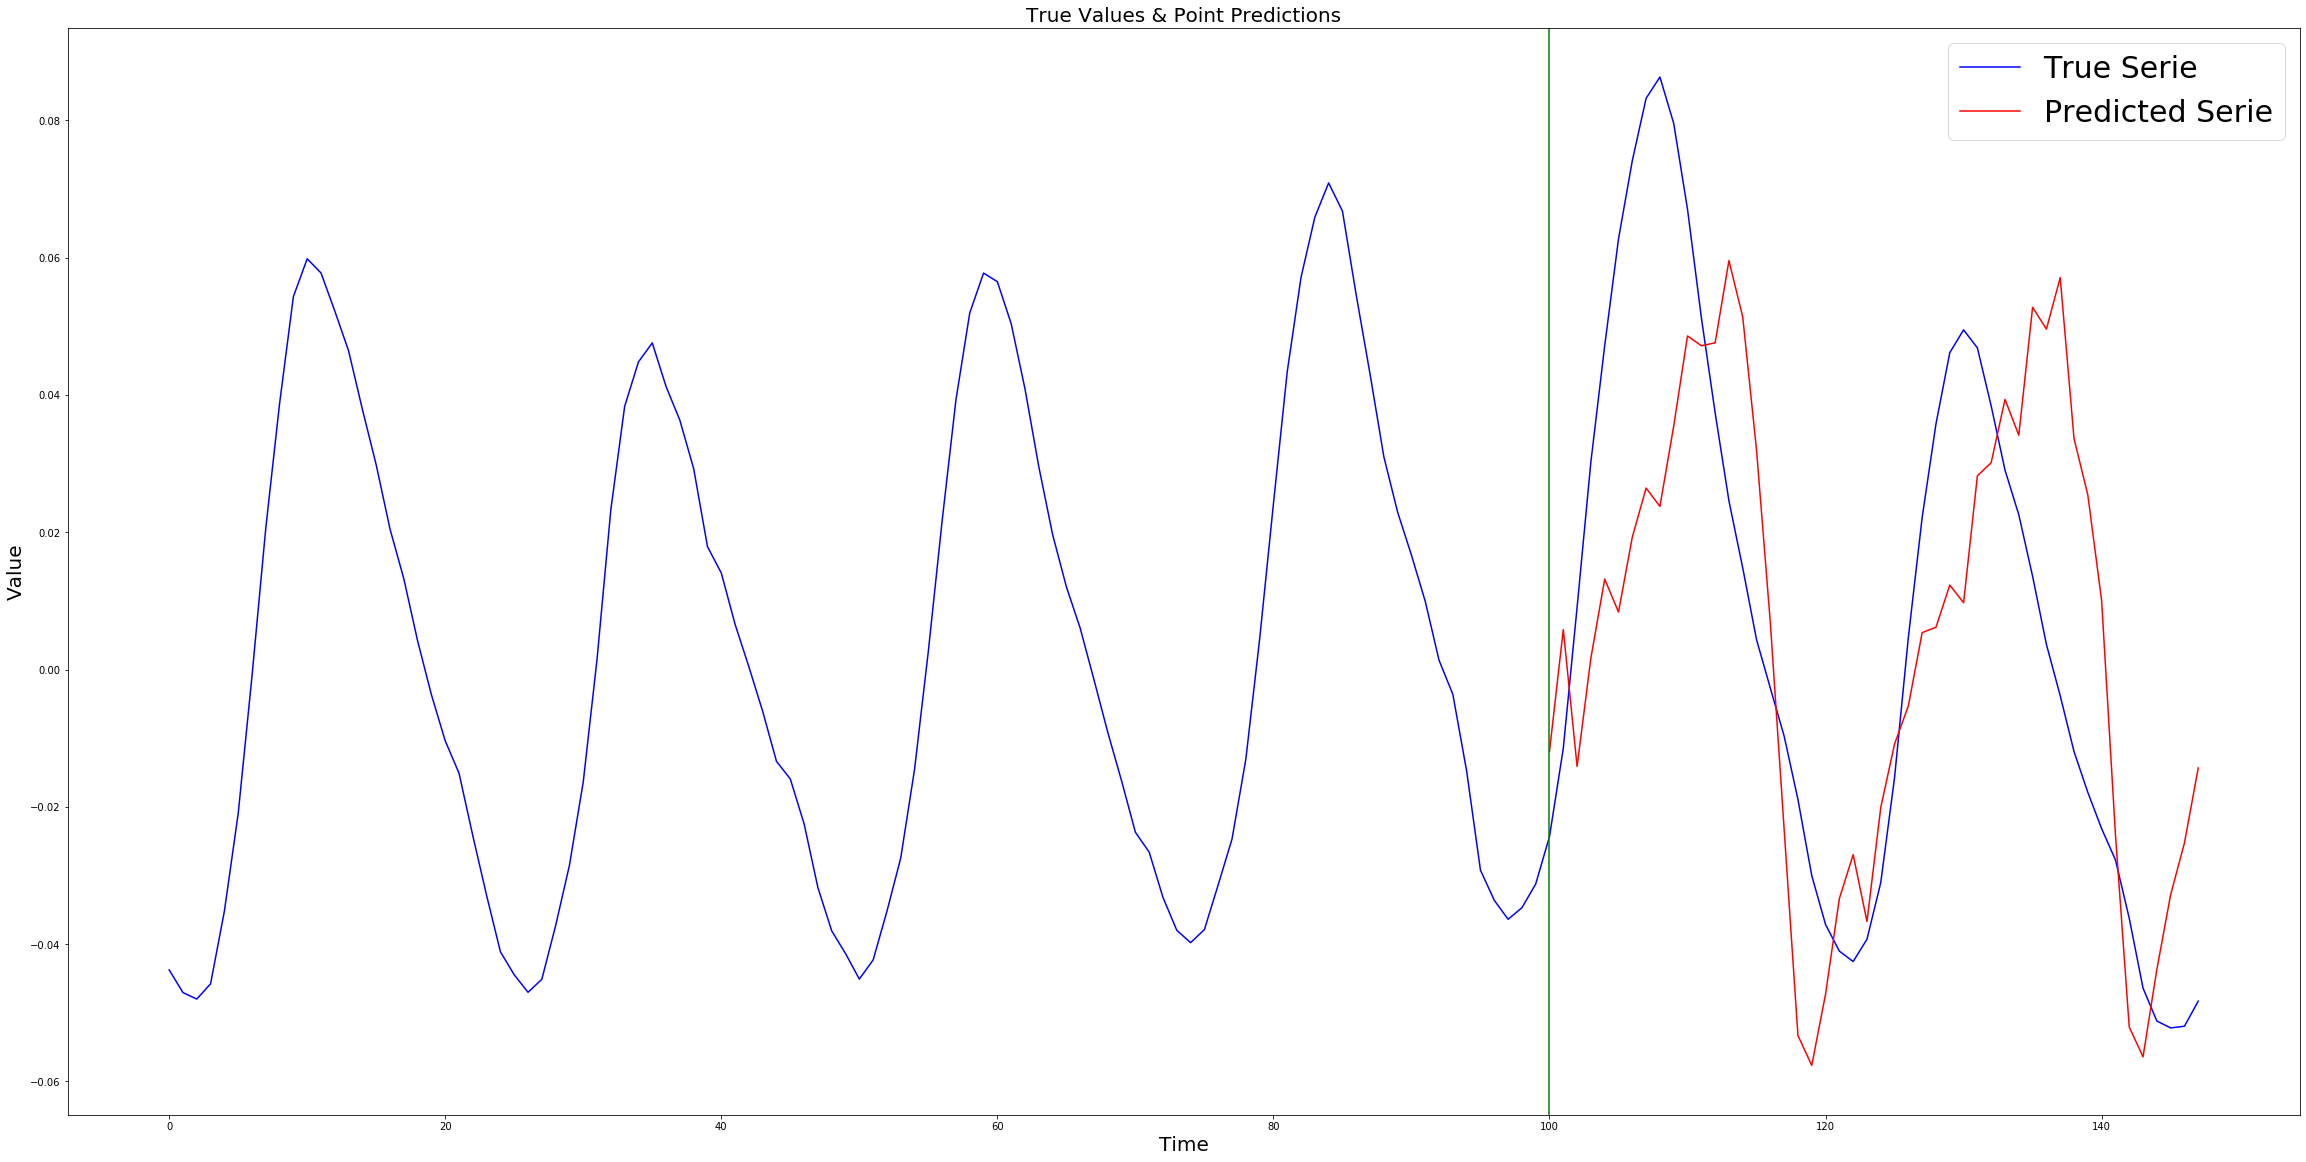

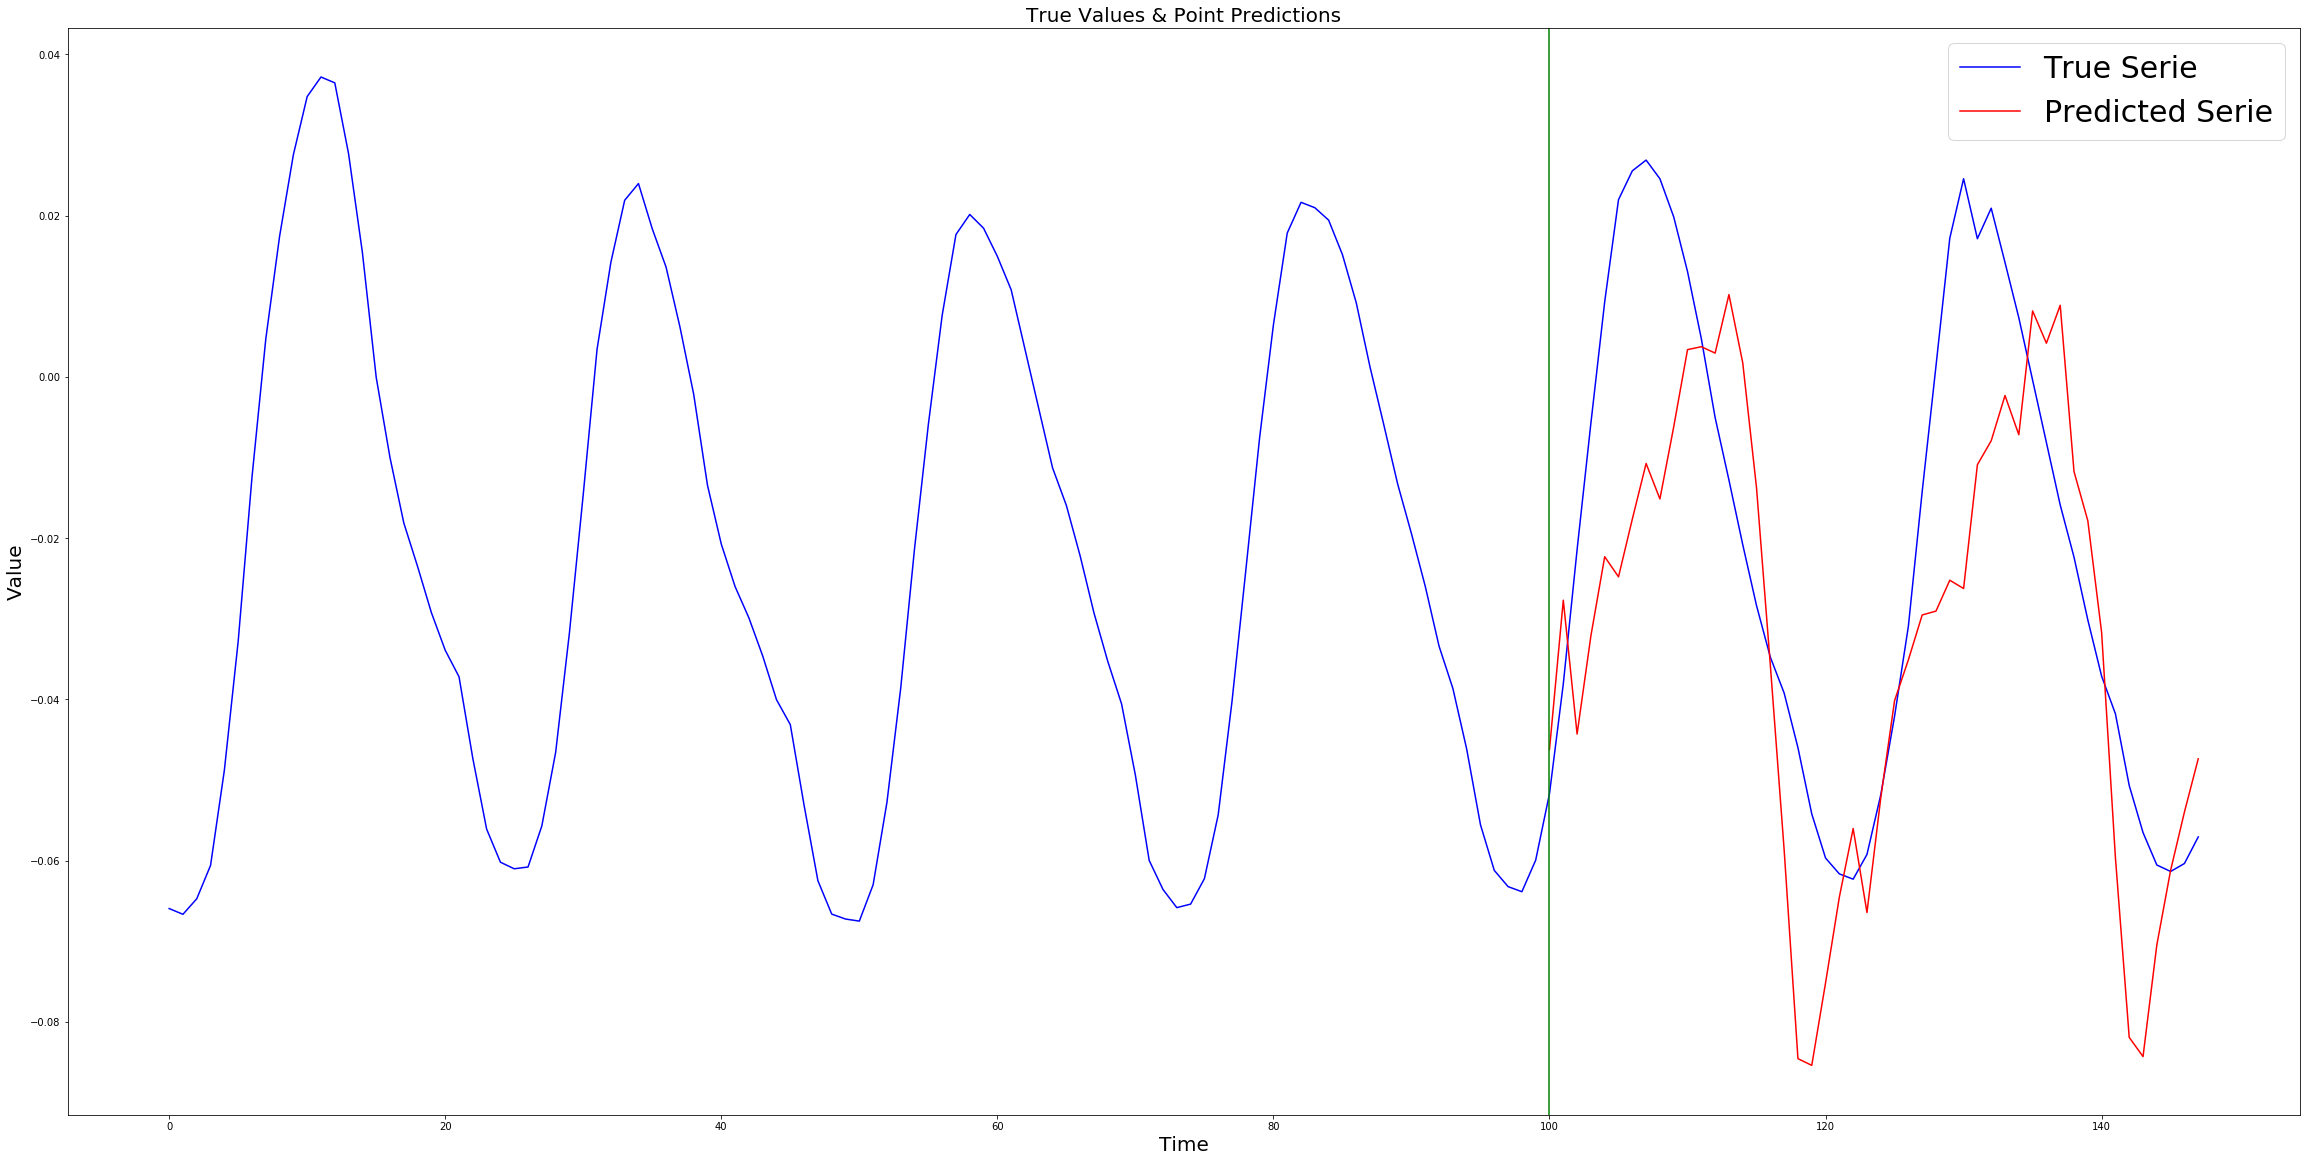

In [3]:
train_x, train_y, test_x, test_y = gen.get_data()

#============ Predict Train
predictedY = model.predict(train_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1), batch_size = BATCH_SIZE)

#plot_series(train_x, train_y, predictedY)
plot_serie_and_prediction(train_x, train_y, predictedY, serie_indx=5)

#============ Predict Test
predictedY = model.predict(test_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1), batch_size = BATCH_SIZE)

#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(test_x, test_y, predictedY, serie_indx=5)

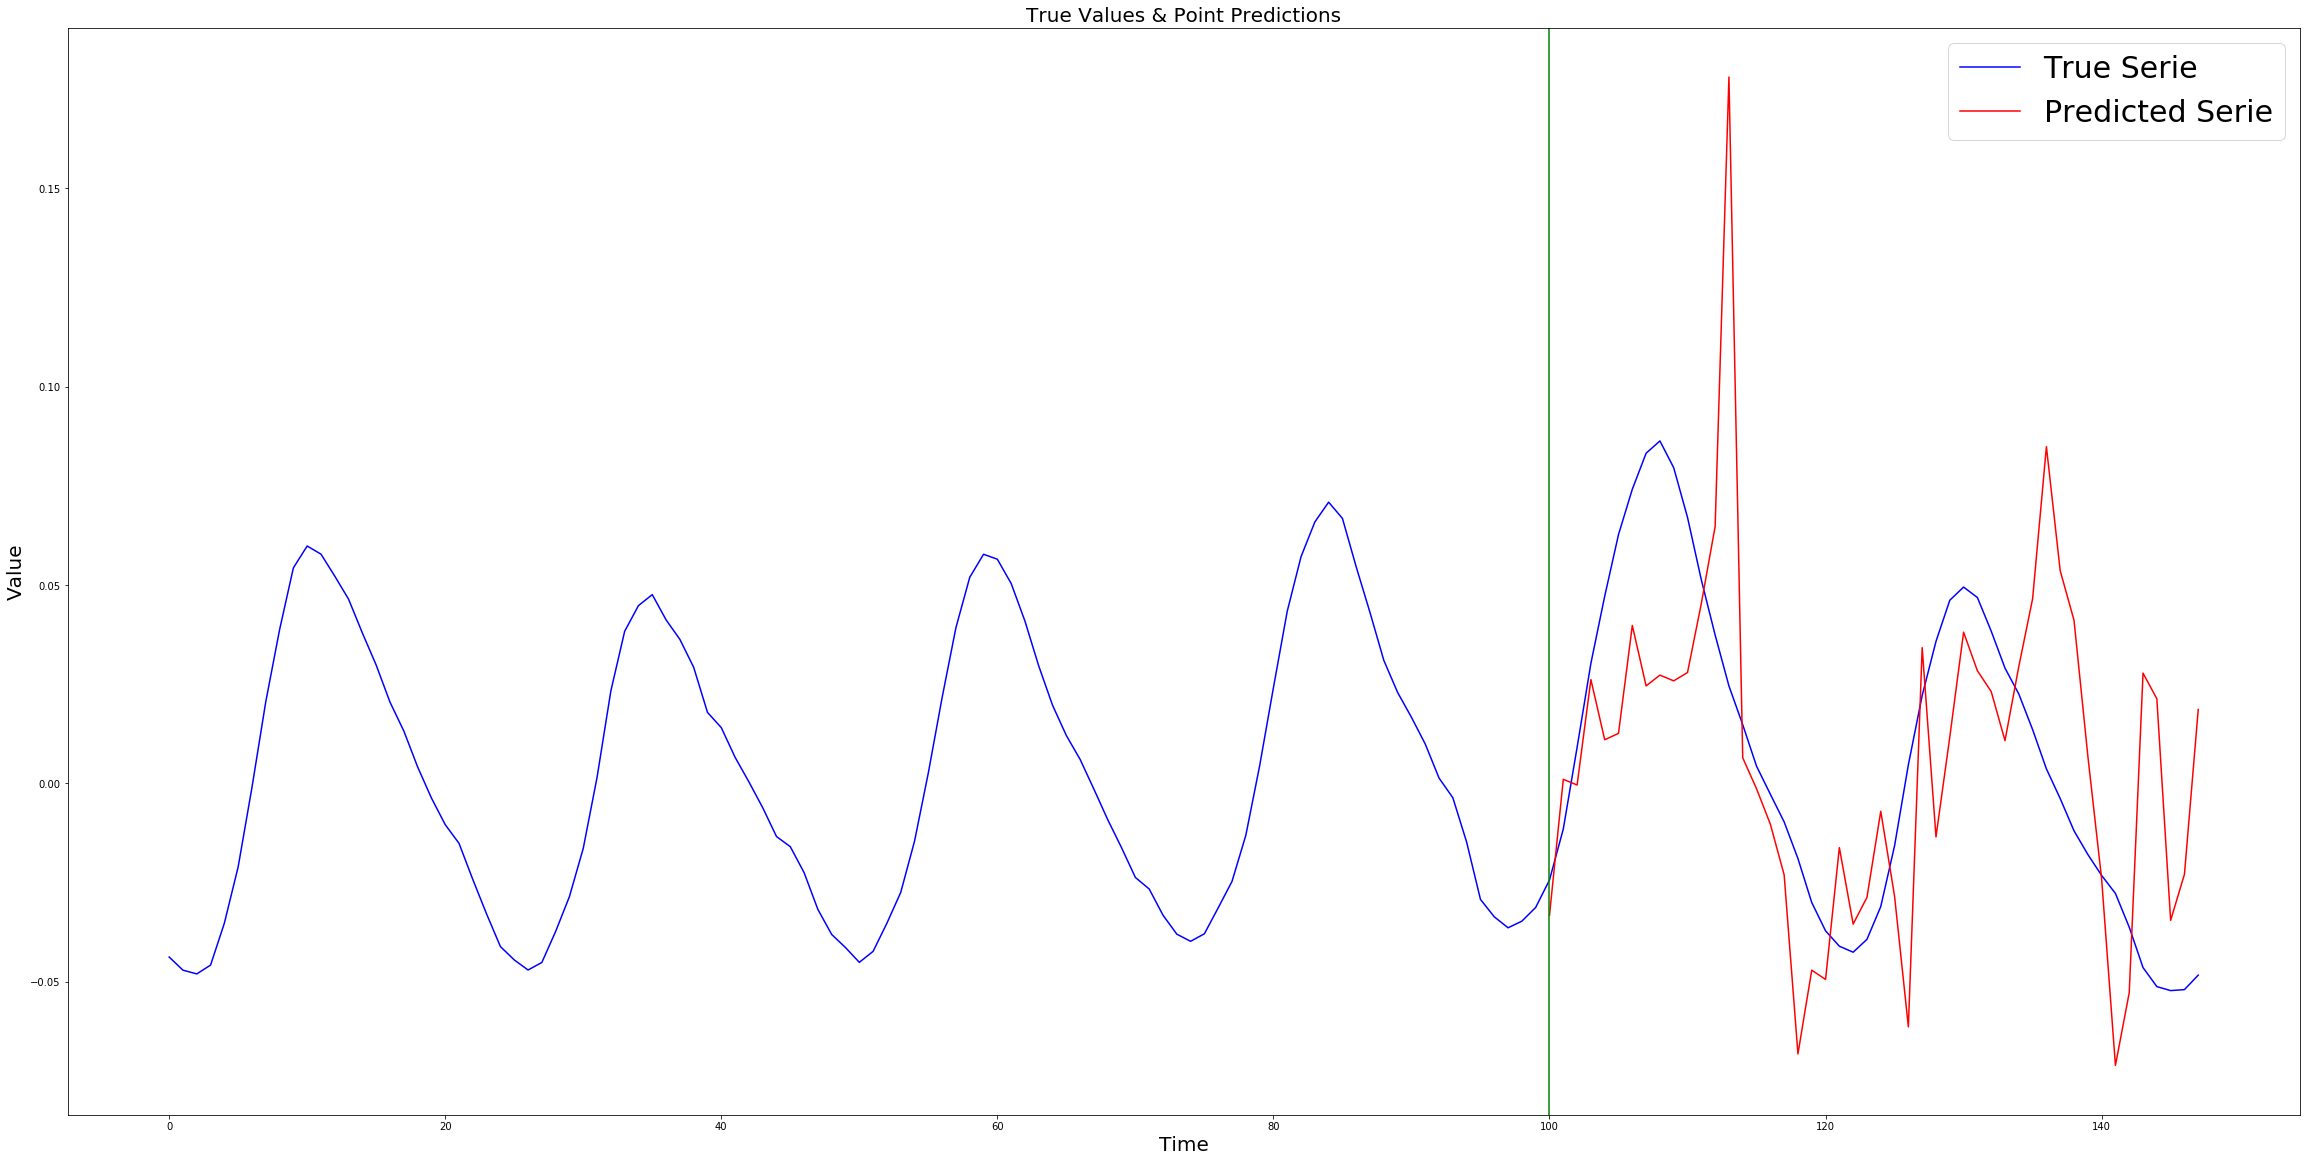

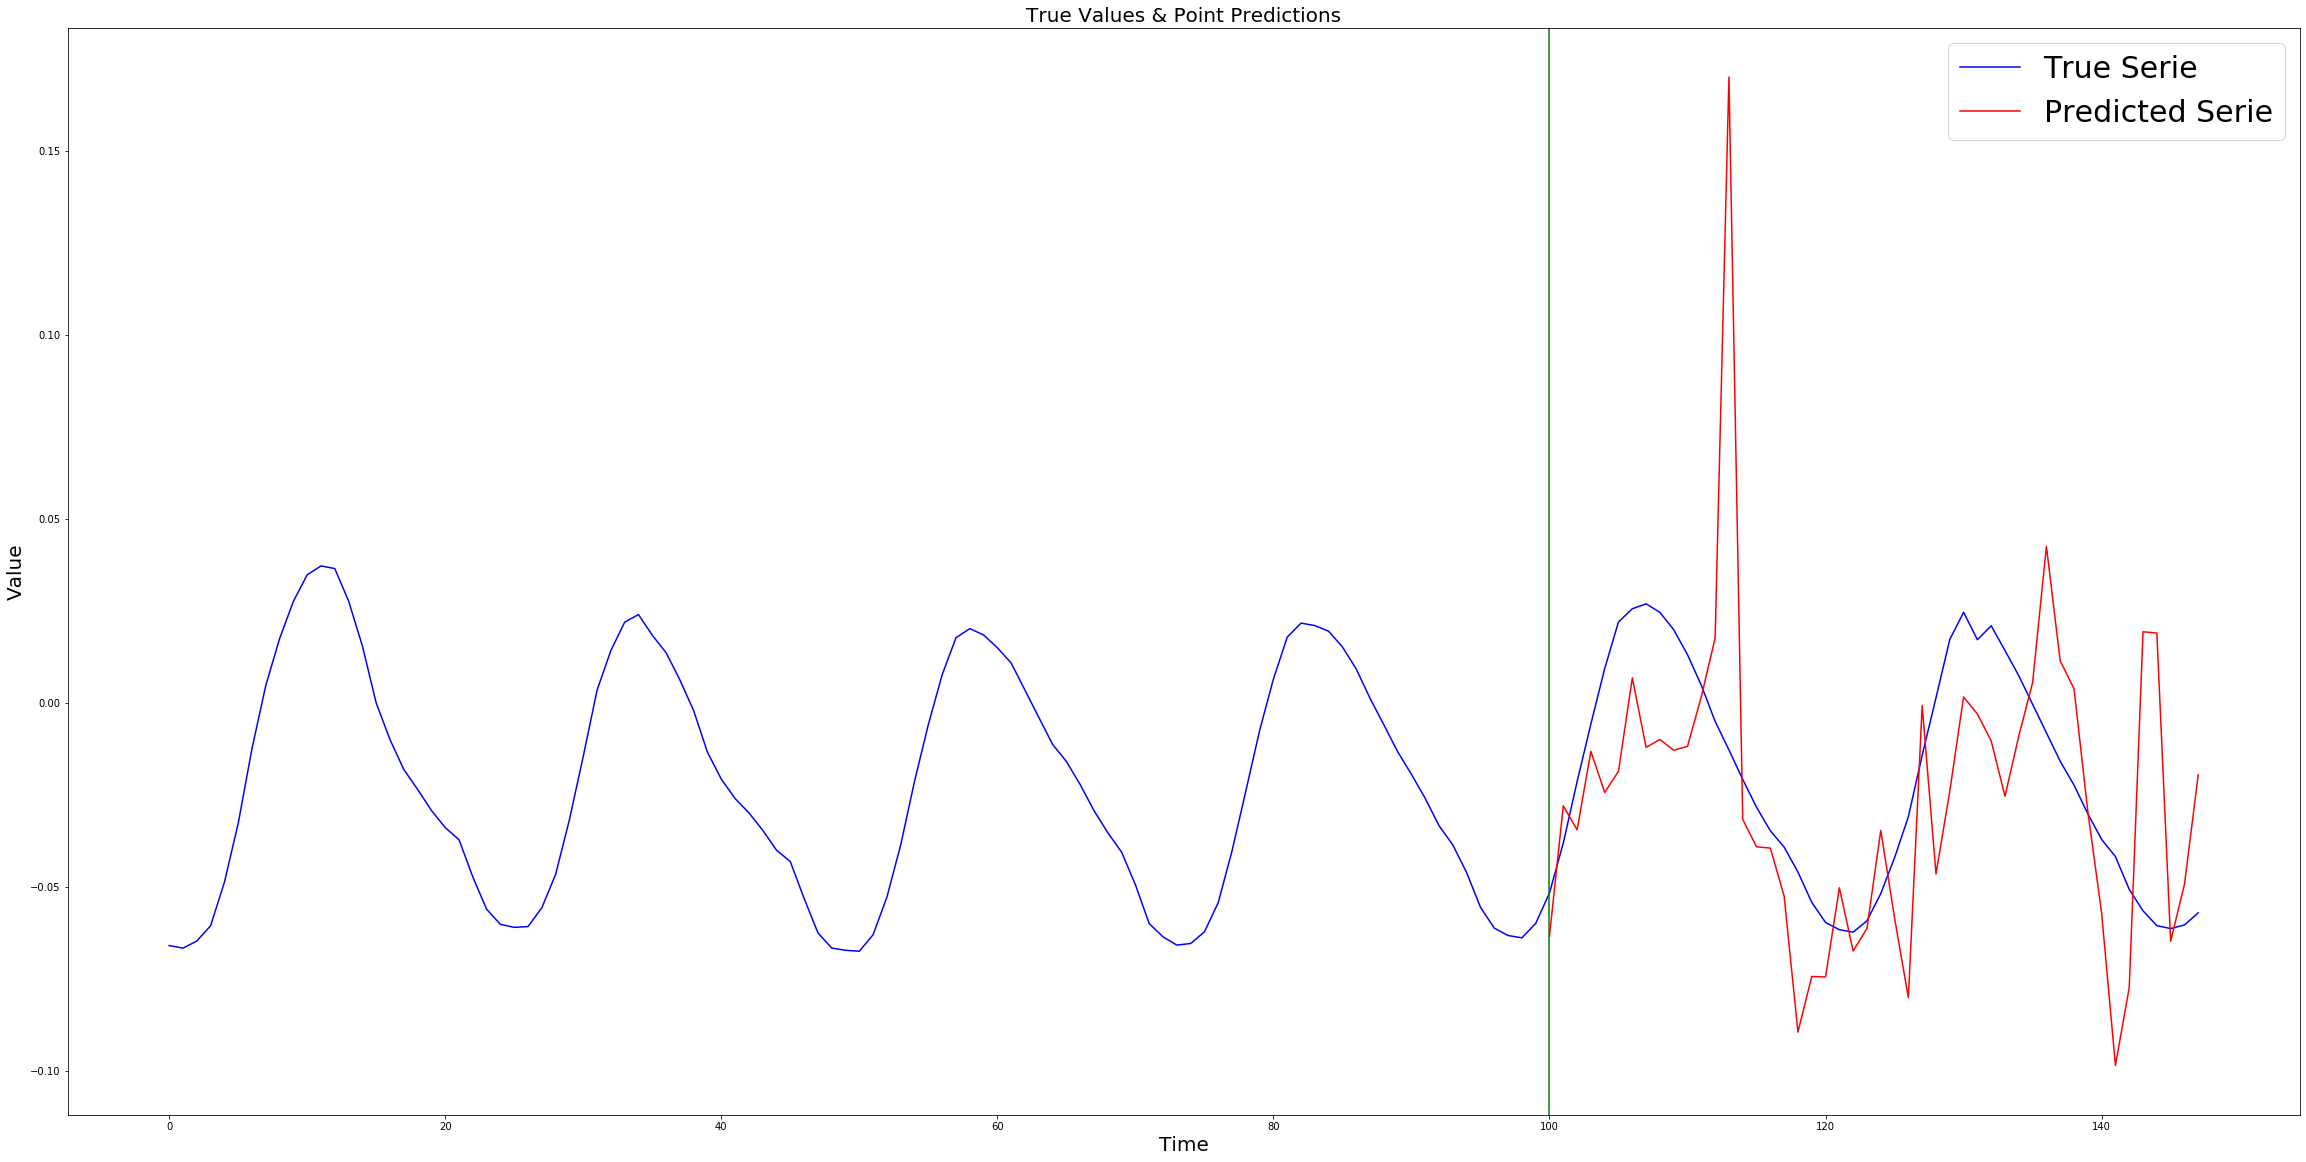

In [5]:
train_x, train_y, test_x, test_y = gen.get_data()

#============ Predict Train
predictedY = model.predict(train_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1), batch_size = BATCH_SIZE)

#plot_series(train_x, train_y, predictedY)
plot_serie_and_prediction(train_x, train_y, predictedY, serie_indx=5)

#============ Predict Test
predictedY = model.predict(test_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1), batch_size = BATCH_SIZE)

#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(test_x, test_y, predictedY, serie_indx=5)